In [1]:
# 필요 라이브러리 import

# Pytorch
import torch
import torch.optim as optim
import torch.nn as nn

# Dataset 관련
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

# 성능 평가 관련
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix

# 최적화
import optuna

# Visualization 관련
import matplotlib.pyplot as plt
import seaborn as sns


'''
딥러닝 학습을 진행할 때, 가중치를 임의의 값으로 초기화하여 학습을 수행하는 데,
실험을 동일하게 진행하기 위해서는 난수를 동일하게 생성해야 한다.
Pytorch에서 random seed를 고정하기 위해 manual_seed를 사용한다.
'''
torch.manual_seed(0)

# 맥북 용
# GPU 사용 가능 환경인지 확인 -> mac의 경우 GPU가 아는 MPS를 사용
print(f"mps 사용 가능 여부: {torch.backends.mps.is_available()}")
print(f"mps 지원 환경 여부: {torch.backends.mps.is_built()}")
device = torch.device("mps")

# 윈도우 용(Colab)
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'{device} is available')


/opt/homebrew/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


mps 사용 가능 여부: True
mps 지원 환경 여부: True
mps is available


In [2]:
# 학습용 데이터 셋 생성 함수
# Sequence data를 만들어서 numpy array로 반환
def build_dataset(data, seq_len):
    dataX = []
    dataY = []
    for i in range(len(data)-seq_len):
        x = data[i:i+seq_len, :]
        y = data[i+seq_len, [-1]]
        dataX.append(x)
        dataY.append(y)
    return np.array(dataX), np.array(dataY)

# 데이터 불러오기
file_path = '../../data/' # for mac
df = pd.read_csv(file_path + 'bitcoin_data_num_rows_gt_9.csv')
df = df.iloc[:1000]
df = df.sort_values(by='window_start', ascending=True) # 시간순 정렬
print("before: ", df.shape)

# 무한대에 해당하는 값 제거
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

# Data Preprocessing
# 필요한 Feature만 추출한 데이터
target_var = df[['returns', 'returns_next10m', 'realized_vol_next10m']] # 종속변수
df.drop(columns=['returns', 'returns_next10m', 'realized_vol_next10m'], inplace=True) # 독립변수
print("after: ", df.shape)
print(df.head())

# 독립변수 카테고리화
target_var['returns_next10m'] = target_var['returns_next10m'].apply(lambda x: 0 if x <= 0 else 1) # 0보다 작으면 0, 0보다 크면 1

# 독립변수 중 사용할 변수만 가져오기(+정규화)
scaler = MinMaxScaler()
X = scaler.fit_transform(df.drop(columns=['window_start', 'window_end', 'num_rows', 'time_id'])) # 위 변수를 제외한 모든 변수
y = target_var['returns_next10m'].values # 종속변수

# 성능을 기록할 데이터프레임
#result_df = pd.DataFrame()

before:  (1000, 84)
after:  (984, 81)
          window_start           window_end  num_rows  lowest_return  \
0  2022-12-16 21:05:30  2022-12-16 21:06:00        14       0.000000   
1  2022-12-16 21:06:00  2022-12-16 21:06:30        10       0.000000   
2  2022-12-16 21:06:30  2022-12-16 21:07:00        24      -0.000576   
3  2022-12-16 21:07:00  2022-12-16 21:07:30        22      -0.000044   
4  2022-12-16 21:07:30  2022-12-16 21:08:00        24      -0.000443   

   highest_return  high_low_gap  trade_vol  volume_power  beginning_price  \
0        0.000089      0.000089   1.468656      0.747351       22568000.0   
1        0.000089      0.000089   0.567585      0.027857       22568000.0   
2        0.000044      0.000620   1.677093      0.146635       22570000.0   
3        0.000443      0.000488   2.439677      0.751995       22557000.0   
4        0.000000      0.000443   2.345821     -0.915608       22565000.0   

   ending_price  ...  ob_end_bp_14  ob_end_bs_14 ob_end_bias_0  ob

/var/folders/yd/1_xwcyjj6z58p2vptxk1dwvm0000gn/T/ipykernel_74105/3477799353.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_var['returns_next10m'] = target_var['returns_next10m'].apply(lambda x: 0 if x <= 0 else 1) # 0보다 작으면 0, 0보다 크면 1


In [3]:
# 시퀀스 데이터 생성
def seq_data(x, y, sequence_length):
    x_seq = []
    y_seq = []
    for i in range(len(x)-sequence_length):
        x_seq.append(x[i:i+sequence_length]) # a[2:6] -> 2,3,4,5
        y_seq.append(y[i+sequence_length])

    # view를 사용하여 2차원으로 바꿈(MSE Loss가 기본적으로 2차원 타깃 데이터를 받음)
    return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)

split = int(len(df)*0.7) # 70%를 학습 데이터로
sequence_length = 8 # 30s * 5 = 2m 30s를 시퀀스 길이로
x_seq, y_seq = seq_data(X, y, sequence_length)
x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]
x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]
print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())


torch.Size([688, 8, 77]) torch.Size([688, 1])
torch.Size([288, 8, 77]) torch.Size([288, 1])


/var/folders/yd/1_xwcyjj6z58p2vptxk1dwvm0000gn/T/ipykernel_74105/1122436012.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1,1)


In [4]:
# Dataset과 DataLoader를 이용해 배치 데이터로 만든다.
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)
batch_size = 64
train_loader =  torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False, drop_last=True) # 시계열 데이터기에 shuffle X, 마지막 batch 버림
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size)

In [5]:
# GRUModel 클래스 정의
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, sequence_length, output_size, num_layers, device):
        super(GRUModel, self).__init__()
        self.device = device
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)  # 출력 크기를 1로 설정

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)  # self.hidden_dim -> self.hidden_size
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        out = torch.sigmoid(out)  # 시그모이드 활성화 함수 적용
        return out

In [6]:
# set hyperparameters
input_size = x_train_seq.size(2) # feature 개수
num_layers = 2 # 은닉층의 개수
hidden_size = 10 # 은닉 상태를 저장하는 벡터의 크기

In [10]:
model = GRUModel(input_size=77, 
                 hidden_size=12, 
                 sequence_length=sequence_length, 
                 output_size=1, 
                 num_layers=2,
                 device=device).to(device)

In [16]:
# 손실 함수와 옵티마이저 정의
criterion = nn.BCELoss()  # 손실 함수를 BCELoss로 변경
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 학습
num_epochs = 10
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)  # 입력 차원 추가
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/10], Loss: 0.7002


In [13]:
model.eval() # 모델을 평가 모드로 설정
with torch.no_grad(): # 기울기 계산을 비활성화하여 메모리 사용량 줄이고 계산 속도 향상
    correct = 0
    total = 0 
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = (outputs > 0.5).float() # 출력이 0.5보다 크면 1, 아니면 0으로 예측
        total += labels.size(0) # 테스트 데이터셋의 전체 샘플 수가 저장(labels.sze(0): 배치에서 레이블(정답)의 총 개수로 배치 크기와 동일)
        correct += (predicted == labels).sum().item() # .item(): 스칼라 값(텐서)을 파이썬의 숫자 타입으로 변환

    print(f'Test Accuracy: {100 * correct / total:.2f}%')

Test Accuracy: 46.88%


In [22]:
def build_sequences(X, y, sequence_length):
    """입력 데이터와 타깃 데이터를 받아 sequence_length에 맞게 데이터를 재조정하는 함수"""
    X_seq, y_seq = [], []
    for i in range(len(X) - sequence_length):
        X_seq.append(X[i:(i + sequence_length)])
        y_seq.append(y[i + sequence_length])
    return np.array(X_seq), np.array(y_seq)

def objective(trial):
    # 하이퍼파라미터 설정
    sequence_length = trial.suggest_int('sequence_length', 5, 20)

    # 데이터를 sequence_length에 맞게 재조정
    X_seq, y_seq = build_sequences(X, y, sequence_length)
    X_seq, y_seq = torch.FloatTensor(X_seq).to(device), torch.FloatTensor(y_seq).to(device).view(-1, 1)
    
    # 데이터셋과 데이터로더 준비
    dataset = TensorDataset(X_seq, y_seq)
    train_loader = DataLoader(dataset, batch_size=64, shuffle=False)

    # 모델, 옵티마이저, 손실 함수 설정
    model = GRUModel(input_size=X_seq.size(2), hidden_size=hidden_size, sequence_length=sequence_length,
                     output_size=1, num_layers=num_layers, device=device).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.BCELoss()

    # 훈련 과정
    for epoch in range(num_epochs):
        for x_batch, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        # 조기 종료 조건 검사
        trial.report(loss.item(), epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return loss.item()

# MedianPruner 추가
pruner = optuna.pruners.MedianPruner()

# Optuna 최적화 실행, pruner 인자 추가
study = optuna.create_study(direction='minimize', pruner=pruner)
study.optimize(objective, n_trials=10)

# 최적의 하이퍼파라미터 출력
print('Best trial:')
trial = study.best_trial
print(f'Value: {trial.value}')
print('Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2024-02-20 13:38:32,774] A new study created in memory with name: no-name-14a2e0e0-26bd-42f5-a80b-4c6fa5ad3f7b
[I 2024-02-20 13:38:48,538] Trial 0 finished with value: 100.0 and parameters: {'sequence_length': 20}. Best is trial 0 with value: 100.0.
[I 2024-02-20 13:38:59,320] Trial 1 finished with value: 100.0 and parameters: {'sequence_length': 14}. Best is trial 0 with value: 100.0.
[I 2024-02-20 13:39:11,217] Trial 2 finished with value: 100.0 and parameters: {'sequence_length': 16}. Best is trial 0 with value: 100.0.
[I 2024-02-20 13:39:19,367] Trial 3 finished with value: 100.00000762939453 and parameters: {'sequence_length': 9}. Best is trial 0 with value: 100.0.
[I 2024-02-20 13:39:24,873] Trial 4 finished with value: 0.7356594204902649 and parameters: {'sequence_length': 6}. Best is trial 4 with value: 0.7356594204902649.
[I 2024-02-20 13:39:38,668] Trial 5 finished with value: 100.0 and parameters: {'sequence_length': 18}. Best is trial 4 with value: 0.7356594204902649.
[I

Best trial:
Value: 0.5528890490531921
Params: 
    sequence_length: 8


In [23]:
# Hyperparameter tunning
import optuna
from optuna import Trial, visualization

def objective(trial):
    # 하이퍼파라미터 설정
    input_size = x_train_seq.size(2) # feature 개수
    output_size = 1
    sequence_length = 8
    #sequence_length = trial.suggest_int('sequence_length', 5, 20)
    num_layers = trial.suggest_int('num_layers', 2, 10)
    hidden_size = trial.suggest_int('hidden_size', 2, 10)
    num_epochs = trial.suggest_int('num_epochs', 200, 1000)
    #dropout = trial.suggest_categorical('dropout', [0.1, 0.2, 0.3, 0.4, 0.5])
    lr = trial.suggest_categorical('lr', [1e-4, 1e-3, 1e-2])

    model = GRUModel(input_size=input_size, hidden_size=hidden_size, sequence_length=sequence_length,
                     output_size=output_size, num_layers=num_layers, device=device).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    # 훈련
    for epoch in range(num_epochs):
        for x_batch, labels in train_loader:
            x_batch, labels = x_batch.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

         # 조기 종료 검사
        trial.report(loss.item(), epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()    

    return loss.item()

# MedianPruner 추가
pruner = optuna.pruners.MedianPruner()

# Optuna 최적화 실행
study = optuna.create_study(direction='minimize', pruner=pruner)
study.optimize(objective, n_trials=5)

# 최적의 하이퍼파라미터 출력
print('Best trial:')
trial = study.best_trial
print(f'Value: {trial.value}')
print('Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2024-02-20 13:40:48,944] A new study created in memory with name: no-name-f1803199-bd75-413f-ad75-384bfa5a6224
[I 2024-02-20 13:54:29,763] Trial 0 finished with value: 100.0 and parameters: {'num_layers': 9, 'hidden_size': 3, 'num_epochs': 516, 'lr': 0.01}. Best is trial 0 with value: 100.0.
[I 2024-02-20 14:02:10,625] Trial 1 finished with value: 100.0 and parameters: {'num_layers': 6, 'hidden_size': 5, 'num_epochs': 404, 'lr': 0.01}. Best is trial 0 with value: 100.0.
[I 2024-02-20 14:11:36,488] Trial 2 finished with value: 100.0 and parameters: {'num_layers': 4, 'hidden_size': 6, 'num_epochs': 721, 'lr': 0.0001}. Best is trial 0 with value: 100.0.
[I 2024-02-20 14:34:55,417] Trial 3 finished with value: 100.0 and parameters: {'num_layers': 6, 'hidden_size': 7, 'num_epochs': 916, 'lr': 0.0001}. Best is trial 0 with value: 100.0.
[I 2024-02-20 14:44:55,128] Trial 4 finished with value: 0.6383315920829773 and parameters: {'num_layers': 2, 'hidden_size': 9, 'num_epochs': 926, 'lr': 0

Best trial:
Value: 0.6383315920829773
Params: 
    num_layers: 2
    hidden_size: 9
    num_epochs: 926
    lr: 0.0001


Epoch [10/926], Loss: 0.6947
Epoch [20/926], Loss: 0.6928
Epoch [30/926], Loss: 0.6908
Epoch [40/926], Loss: 0.6888
Epoch [50/926], Loss: 0.6869
Epoch [60/926], Loss: 0.6850
Epoch [70/926], Loss: 0.6831
Epoch [80/926], Loss: 0.6812
Epoch [90/926], Loss: 0.6794
Epoch [100/926], Loss: 0.6778
Epoch [110/926], Loss: 0.6763
Epoch [120/926], Loss: 0.6749
Epoch [130/926], Loss: 0.6737
Epoch [140/926], Loss: 0.6725
Epoch [150/926], Loss: 0.6715
Epoch [160/926], Loss: 0.6705
Epoch [170/926], Loss: 0.6696
Epoch [180/926], Loss: 0.6687
Epoch [190/926], Loss: 0.6679
Epoch [200/926], Loss: 0.6672
Epoch [210/926], Loss: 0.6664
Epoch [220/926], Loss: 0.6656
Epoch [230/926], Loss: 0.6649
Epoch [240/926], Loss: 0.6641
Epoch [250/926], Loss: 0.6632
Epoch [260/926], Loss: 0.6623
Epoch [270/926], Loss: 0.6613
Epoch [280/926], Loss: 0.6602
Epoch [290/926], Loss: 0.6589
Epoch [300/926], Loss: 0.6577
Epoch [310/926], Loss: 0.6569
Epoch [320/926], Loss: 0.6560
Epoch [330/926], Loss: 0.6544
Epoch [340/926], Lo

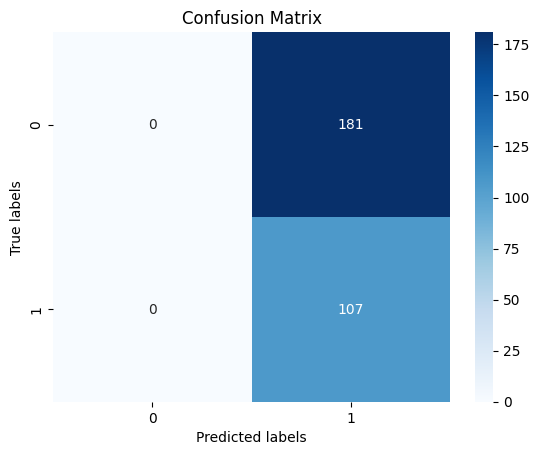

In [26]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 최적 하이퍼파라미터 사용하여 모델 초기화
best_trial = study.best_trial
model = GRUModel(
    input_size=x_train_seq.size(2),
    hidden_size=best_trial.params['hidden_size'],
    sequence_length=8,
    output_size=1,
    num_layers=best_trial.params['num_layers'],
    device=device).to(device)

# 모델 훈련을 위한 설정
optimizer = torch.optim.Adam(model.parameters(), lr=best_trial.params['lr'])  # 최적화 알고리즘 설정
criterion = nn.BCELoss()  # 손실 함수 설정 (이진 분류를 가정)

# 훈련 과정 설정
num_epochs = best_trial.params['num_epochs']  # 에폭 수

# 훈련 시작
model.train()  # 모델을 훈련 모드로 설정
for epoch in range(num_epochs):
    for x_batch, labels in train_loader:
        x_batch, labels = x_batch.to(device), labels.to(device)
        
        # 순전파: 모델에 데이터를 입력하여 예측값을 계산
        outputs = model(x_batch)
        
        # 손실 계산
        loss = criterion(outputs, labels)
        
        # 역전파: 손실에 대한 모델의 매개변수들의 미분값을 계산
        optimizer.zero_grad()  # 기울기 초기화
        loss.backward()  # 역전파 실행
        
        # 매개변수 업데이트
        optimizer.step()
    
    # 에폭마다 진행 상황 출력
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 테스트 데이터 예측
model.eval()  # 모델을 평가 모드로 설정
y_true = []
y_pred = []
with torch.no_grad():
    for x_batch, labels in test_loader:
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        preds = torch.round(outputs).cpu().numpy()  # 이진 분류를 가정
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds)

# 성능 지표 계산
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# 결과 출력
print(f'Accuracy: {accuracy.round(4)}')
print(f'Precision: {precision.round(4)}')
print(f'Recall: {recall.round(4)}')
print(f'F1 Score: {f1.round(4)}')

# 혼동 행렬 출력
conf_mat = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import torchmetrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 메트릭 초기화
accuracy = torchmetrics.Accuracy().to(device)
precision = torchmetrics.Precision().to(device)
recall = torchmetrics.Recall().to(device)
f1 = torchmetrics.F1().to(device)

# 예측값과 실제값을 저장할 리스트 초기화
y_pred_list = []
y_true_list = []

model.eval()
with torch.no_grad():
    for x_batch, labels in test_loader:
        x_batch, labels = x_batch.to(device), labels.to(device)
        outputs = model(x_batch)
        
        # 클래스 예측값을 계산합니다 (이진 분류의 경우)
        preds = torch.round(outputs)
        
        # 메트릭 업데이트
        accuracy(preds, labels.int())
        precision(preds, labels.int())
        recall(preds, labels.int())
        f1(preds, labels.int())
        
        # 혼동 행렬을 위해 예측값과 실제값 저장
        y_pred_list.extend(preds.view(-1).cpu().numpy())
        y_true_list.extend(labels.view(-1).cpu().numpy())

# 메트릭 출력
print(f'Accuracy: {accuracy.compute()}')
print(f'Precision: {precision.compute()}')
print(f'Recall: {recall.compute()}')
print(f'F1 Score: {f1.compute()}')

# 혼동 행렬 계산 및 출력
conf_mat = confusion_matrix(y_true_list, y_pred_list)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()
